# TORCH.NN 이 실제로 무엇인가요?

- PyTorch는 `torch.nn`, `torch.optim`, `Dataset`, `DataLoader`와 같은 잘 디자인된 모듈과 클래스들을 제공하며, 이들의 기능에 대해 알아본다.
- 먼저 PyTorch 텐서(tensor) 기능만을 사용해 MNIST에 대한 기초적인 신경망을 만들어 본 후, `torch.nn`, `torch.optim`, `Dataset`, `DataLoader`를 하나씩 추가하면서, 정확히 각 부분이 어떤 일을 하는지 그리고 이것이 어떻게 코드를 더 정확하고 유연하게 만드는지 학습한다.

## 1. 데이터셋 불러오기

- [MNIST](http://deeplearning.net/data/mnist/)는 손으로 쓴 숫자(0에서 9 사이)의 흑백 이미지로 구성된 데이터셋

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

# 데이터 내려받기
if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

#### `pickle` vs. `json`

- 파이썬에서 텍스트뿐만 아니라 객체와 같은 데이터들을 읽고 쓸때 사용할 수 있는 모듈인데, [pickle](https://docs.python.org/ko/3/library/pickle.html)를 보니 보안에 취약한 것 같음
- 되도록이면 [json](https://docs.python.org/ko/3/library/json.html#module-json)을 사용하자!

In [2]:
import pickle
import gzip

# 데이터 불러오기
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


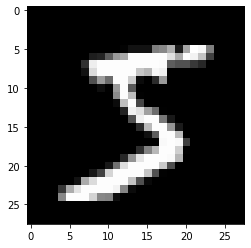

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 확인
plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [4]:
import torch

# Numpy array를 torch.tensor로 변환
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

print(x_train)
print(x_train.size()) 
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([50000, 784])
tensor(0) tensor(9)


## 2. `torch.nn` 없이 밑바닥부터 신경망 만들기

### 2-1. 신경망 정의

In [5]:
import math

# Xaiver initialization : 1/sqrt(n)을 곱해주기
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_() # weights.requires_grad = True와 동일
bias = torch.zeros(10, requires_grad=True)

def model(x):
    return x.mm(weights) + bias

### 2-2. 출력 및 손실함수 계산

#### Softmax

$x \in \mathbb{R}^n$가 입력으로 주어질 때, softmax 함수는 다음과 같다.

$$S(x) = y \in \mathbb{R}^n \ \ \text{where}\ \ y_i = \dfrac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$$

#### Negative Log-Likelihood Loss (NLL Loss)

Negative log-likelihood는 말 그대로 likelihood에 로그를 취한 값의 음의 값을 의미한다. 따라서, likelihood $p$가 입력으로 주어졌을 때 negative log-likelihood 함수는 다음과 같다.

$$L(p) = -\log(p)$$

하지만, 우리가 Loss function으로 사용하기 위해서는 정답 index에 해당하는 값만을 optimize해야하므로, target class에 해당하는 값만을 따로 꺼내주는 작업이 필요하다.

따라서, $n$개의 class에 대한 likelihood $p \in \mathbb{R}^n$와 정답 label의 index에 대한 정보를 담고있는 $c$가 주어졌을 때, NLL Loss는 다음과 같이 계산한다.

$$L(p) = -\log(p_c)$$

#### Summary

모델의 출력이 주어졌을 때, softmax, NLL을 통해 Loss가 구해지는 전체 과정은 아래 그림과 같다.
<img src="./assets/nll_loss.jpg" alt="nll_loss" width="75%"/>

In [6]:
"""
softmax
"""
def softmax(x):
    # (각 element에 지수함수를 취한 값) / (각 element에 지수함수를 취한 값들의 합)
    # 이때, 분모는 스칼라이므로 unsqueeze로 차원을 늘린 후 나눠서 broadcasting되도록 함
    # 
    # softmax의 결과는 각 label에 대한 확률값 형태로 나오게 됨
    # 즉, 데이터 instance마다 10개의 element로 이루어진 vector인데,
    # 이 vector의 각 element들은 모두 해당하는 label에 대한 확률값이 됨
    return x.exp() / x.exp().sum(-1).unsqueeze(-1)

In [7]:
"""
negative log-likelihood
"""
def nll_loss(probs, targets):
    # range(targets.shape()[0]) : 각 data instance의 index
    # targets : 정답 label
    #
    # 즉, 각 instance별로 예측한 값(preds)에 음의 log-softmax를 취한 값들 중에서
    # 정답 label 위치의 값들의 평균을 반환하는 것
    return -torch.log(probs)[range(targets.shape[0]), targets].mean()

In [8]:
import torch.nn.functional as F

batch_size = 64
x_batch = x_train[0:batch_size]
y_batch = y_train[0:batch_size]

out = model(x_batch)
y_softmax = softmax(out)
loss = nll_loss(y_softmax, y_batch)
print(loss)

# pytorch의 torch.nn.functional의 nll_loss는 softmax에 log를 취한 값을 input으로 주어야 함
print(F.nll_loss(torch.log(y_softmax), y_batch))

tensor(2.3802, grad_fn=<NegBackward>)
tensor(2.3802, grad_fn=<NllLossBackward>)


### 2-3. 정확도 (accuracy) 계산

In [9]:
def accuracy(out, target):
    y_preds = torch.argmax(out, dim=1)
    return (y_preds == target).float().mean()

In [10]:
acc = accuracy(y_softmax, y_batch)
print(acc)

tensor(0.0938)


### 2-4. Training Loop

매 훈련 루프(training loop)마다 다음의 과정을 반복
- 데이터를 mini-batch 단위로 load
- 모델을 사용해 prediction
- 정답과 비교해 loss 계산
- `loss.backward()` 를 이용해 모델 가중치 update

In [11]:
def loss_fn(out, target):
    return nll_loss(softmax(out), target)

In [12]:
n = x_train.shape[0]
n_epochs = 10
lr = 0.5

for epoch in range(n_epochs):
    total_train_loss = 0
    for i in range((n // batch_size) + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        
        x_batch = x_train[start_i:end_i]
        y_batch = y_train[start_i:end_i]
        
        out = model(x_batch)
        loss = loss_fn(out, y_batch)
        total_train_loss += loss.item()
        loss.backward()
        
        with torch.no_grad():
            weights -= lr * weights.grad
            bias -= lr * bias.grad
            weights.grad.zero_()
            bias.grad.zero_()
            
    print(
        (f"[Epoch {epoch + 1:2d}] " + 
        f"train_loss: {(total_train_loss / (n // batch_size + 1)):.4f}")
    )

[Epoch  1] train_loss: 0.3868
[Epoch  2] train_loss: 0.3087
[Epoch  3] train_loss: 0.2953
[Epoch  4] train_loss: 0.2879
[Epoch  5] train_loss: 0.2828
[Epoch  6] train_loss: 0.2790
[Epoch  7] train_loss: 0.2760
[Epoch  8] train_loss: 0.2735
[Epoch  9] train_loss: 0.2713
[Epoch 10] train_loss: 0.2695


In [13]:
print(accuracy(model(x_train), y_train))

tensor(0.9230)


## 3. `torch.nn.functional` 사용하기

- PyTorch의 `nn` 클래스를 활용해 더 간결하고 유연하도록 코드를 리팩토링(refactoring)할 수 있음
- Activation function, loss function은 `torch.nn.functional`의 함수로 대체 가능 (`torch.nn.functional`은 F namespace로 import 하는것이 관례)
    - Softmax, NLL을 사용한 Loss function은 Pytorch의 `F.cross_entropy`으로 대체 (`F.nll_loss`도 있기는 하지만, 2단계의 과정을 1단계로 수행할 수 있어서 `F.cross_entropy`가 더 편리함)

In [14]:
import torch.nn.functional as F

loss_fn = F.cross_entropy

def model(x):
    return x.mm(weights) + bias.unsqueeze(0)

In [15]:
print(loss_fn(model(x_train), y_train), accuracy(model(x_train), y_train))

tensor(0.2732, grad_fn=<NllLossBackward>) tensor(0.9230)


## 4. `nn.Module` 을 이용하여 리팩토링 하기

- `nn.Module` 및 `nn.Parameter`를 사용해 더 명확하고 간결한 train loop를 작성 가능
- `nn.Module`의 subclass 형태로 모델을 구현

In [16]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, x):
        return x.mm(self.weights) + self.bias


model = Mnist_Logistic()

In [17]:
def fit():
    for epoch in range(n_epochs):
        total_train_loss = 0
        for i in range((n // batch_size) + 1):
            start_i = i * batch_size
            end_i = start_i + batch_size
            
            x_batch = x_train[start_i:end_i]
            y_batch = y_train[start_i:end_i]
            
            out = model(x_batch)
            loss = loss_fn(out, y_batch)
            total_train_loss += loss.item()
            loss.backward()
            
            # with torch.no_grad():
            #     weights -= lr * weights.grad
            #     bias -= lr * bias.grad
            #     weights.grad.zero_()
            #     bias.grad.zero_()

            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
                
        print(
            (f"[Epoch {epoch + 1:2d}] " + 
            f"train_loss: {(total_train_loss / (n // batch_size + 1)):.4f}")
        )

In [18]:
fit()

[Epoch  1] train_loss: 0.3860
[Epoch  2] train_loss: 0.3087
[Epoch  3] train_loss: 0.2953
[Epoch  4] train_loss: 0.2879
[Epoch  5] train_loss: 0.2828
[Epoch  6] train_loss: 0.2790
[Epoch  7] train_loss: 0.2760
[Epoch  8] train_loss: 0.2735
[Epoch  9] train_loss: 0.2713
[Epoch 10] train_loss: 0.2695


In [19]:
print(accuracy(model(x_train), y_train))

tensor(0.9229)


## 5. `optim` 을 이용하여 리팩토링 하기

- `torch.optim`은 Pytorch의 다양한 최적화(optimization) 알고리즘을 담고 있는 패키지
- optimizer의 `step()`을 사용하면, 각 매개변수를 수동으로 업데이트하는 과정을 생략할 수 있음

In [20]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

In [21]:
def fit():
    for epoch in range(n_epochs):
        total_train_loss = 0
        for i in range((n // batch_size) + 1):
            start_i = i * batch_size
            end_i = start_i + batch_size
            
            x_batch = x_train[start_i:end_i]
            y_batch = y_train[start_i:end_i]
            
            out = model(x_batch)
            loss = loss_fn(out, y_batch)
            total_train_loss += loss.item()
            loss.backward()

            # with torch.no_grad():
            #     for p in model.parameters():
            #         p -= p.grad * lr
            #     model.zero_grad()

            optimizer.step()
            optimizer.zero_grad()
                
        print(
            (f"[Epoch {epoch + 1:2d}] " + 
            f"train_loss: {(total_train_loss / (n // batch_size + 1)):.4f}")
        )

In [22]:
model, optimizer = get_model()
fit()

[Epoch  1] train_loss: 0.3864
[Epoch  2] train_loss: 0.3086
[Epoch  3] train_loss: 0.2952
[Epoch  4] train_loss: 0.2877
[Epoch  5] train_loss: 0.2827
[Epoch  6] train_loss: 0.2789
[Epoch  7] train_loss: 0.2758
[Epoch  8] train_loss: 0.2733
[Epoch  9] train_loss: 0.2712
[Epoch 10] train_loss: 0.2693


In [23]:
print(accuracy(model(x_train), y_train))

tensor(0.9231)


## 6. `Dataset` 을 이용하여 리팩토링하기

- `Dataset` 은 `__len__()` 및 `__getitem__()`를 가진 어떤 것이라도 될 수 있으며, 이 함수들을 indexing하기 위한 방법으로 사용
- `TensorDataset` 은 텐서를 감싸는(wrapping) Dataset이며, 길이와 인덱싱 방식을 정의함으로써 텐서의 첫 번째 차원을 따라 반복, 인덱싱 및 슬라이스(slice)하는 방법을 제공

In [24]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)

In [25]:
def fit():
    for epoch in range(n_epochs):
        total_train_loss = 0
        
        for i in range((n // batch_size) + 1):
            start_i = i * batch_size
            end_i = start_i + batch_size
            
            # x_batch = x_train[start_i:end_i]
            # y_batch = y_train[start_i:end_i]

            x_batch, y_batch = train_ds[start_i:end_i]
            
            out = model(x_batch)
            loss = loss_fn(out, y_batch)
            total_train_loss += loss.item()

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
                
        print(
            (f"[Epoch {epoch + 1:2d}] " + 
            f"train_loss: {(total_train_loss / (n // batch_size + 1)):.4f}")
        )

In [26]:
model, optimizer = get_model()
fit()

[Epoch  1] train_loss: 0.3863
[Epoch  2] train_loss: 0.3086
[Epoch  3] train_loss: 0.2953
[Epoch  4] train_loss: 0.2879
[Epoch  5] train_loss: 0.2828
[Epoch  6] train_loss: 0.2790
[Epoch  7] train_loss: 0.2760
[Epoch  8] train_loss: 0.2735
[Epoch  9] train_loss: 0.2713
[Epoch 10] train_loss: 0.2695


In [27]:
print(accuracy(model(x_train), y_train))

tensor(0.9229)


## 7. `DataLoader`를 이용하여 리팩토링하기

- `DataLoader` 는 배치들에 대해서 반복하기 쉽게 만들어주며, 모든 `Dataset` 으로부터 `DataLoader` 를 생성할 수 있음

In [28]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size)

In [29]:
def fit():
    for epoch in range(n_epochs):
        total_train_loss = 0
        # for i in range((n // batch_size) + 1):
        #     start_i = i * batch_size
        #     end_i = start_i + batch_size
        #     x_batch, y_batch = train_ds[start_i:end_i]

        for x_batch, y_batch in train_dl:
            out = model(x_batch)
            loss = loss_fn(out, y_batch)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
                
        print(
            (f"[Epoch {epoch + 1:2d}] " + 
            f"train_loss: {(total_train_loss / len(train_dl)):.4f}")
        )

In [30]:
model, optimizer = get_model()
fit()

[Epoch  1] train_loss: 0.3871
[Epoch  2] train_loss: 0.3089
[Epoch  3] train_loss: 0.2954
[Epoch  4] train_loss: 0.2879
[Epoch  5] train_loss: 0.2829
[Epoch  6] train_loss: 0.2790
[Epoch  7] train_loss: 0.2760
[Epoch  8] train_loss: 0.2735
[Epoch  9] train_loss: 0.2713
[Epoch 10] train_loss: 0.2695


In [31]:
print(accuracy(model(x_train), y_train))

tensor(0.9228)


## 8. 검증(validation) 추가하기

- Validation data의 shuffling은 필요 없음
    - Validation loss는 검증 데이터셋을 섞든 안섞든 동일하기 때문
    - Train data의 shuffling은 batch와 overfitting 사이의 상관관계를 방지하기 위해 중요
- Validation set의 batch size는 train set보다 크게 해서 loss를 빠르게 계산
    - Validation set에 대해서는 backprop이 필요하지 않으므로, gradient를 저장하지 않아도 되고 이는 메모리를 덜 사용하게된다는 것을 의미

In [32]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)

In [33]:
def fit():
    for epoch in range(n_epochs):
        total_train_loss = 0
        total_valid_loss = 0

        model.train()
        for x_batch, y_batch in train_dl:
            out = model(x_batch)
            loss = loss_fn(out, y_batch)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                out = model(x_batch)
                total_valid_loss += loss_fn(out, y_batch).item()
                
        print(
            (f"[Epoch {epoch + 1:2d}] " + 
            f"train_loss: {(total_train_loss / len(train_dl)):.4f} / " +
            f"valid_loss: {(total_valid_loss / len(valid_dl)):.4f}")
        )

In [34]:
model, optimizer = get_model()
fit()

[Epoch  1] train_loss: 0.3899 / valid_loss: 0.2909
[Epoch  2] train_loss: 0.3114 / valid_loss: 0.3031
[Epoch  3] train_loss: 0.2974 / valid_loss: 0.2908
[Epoch  4] train_loss: 0.2910 / valid_loss: 0.2835
[Epoch  5] train_loss: 0.2852 / valid_loss: 0.2782
[Epoch  6] train_loss: 0.2811 / valid_loss: 0.2784
[Epoch  7] train_loss: 0.2792 / valid_loss: 0.2782
[Epoch  8] train_loss: 0.2767 / valid_loss: 0.2697
[Epoch  9] train_loss: 0.2733 / valid_loss: 0.2779
[Epoch 10] train_loss: 0.2727 / valid_loss: 0.3184


In [35]:
print(accuracy(model(x_train), y_train))

tensor(0.9071)


## 9. `fit()` 와 `get_data()` 생성하기

- `loss_batch()`
    - Train과 validation에 대해 loss를 계산하는 process가 동일하므로, refactoring한 것
    - 하나의 mini-batch에 대해 loss를 계산
- `fit()`
    - 모델을 훈련하고 각 epoch에 대한 train과 validation loss를 계산
- `get_data()`
    - train과 validation set에 대한 `DataLoader`를 반환

In [36]:
def loss_batch(model, loss_fn, x_batch, y_batch, optimizer=None):
    loss = loss_fn(model(x_batch), y_batch)

    if optimizer:
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return loss.item()

In [37]:
import numpy as np

def fit(n_epochs, model, loss_fn, optimizer, train_dl, valid_dl):
    for epoch in range(n_epochs):
        train_losses = []
        valid_losses = []

        model.train()
        for x_batch, y_batch in train_dl:
            loss = loss_batch(model, loss_fn, x_batch, y_batch, optimizer)
            train_losses.append(loss)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                loss = loss_batch(model, loss_fn, x_batch, y_batch)
                valid_losses.append(loss)

        print(
            (f"[Epoch {epoch + 1:2d}] " + 
            f"train_loss: {np.mean(train_losses):.4f} / " +
            f"valid_loss: {np.mean(valid_losses):.4f}")
        )

In [38]:
def get_data(train_ds, valid_ds, batch_size):
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(valid_ds, batch_size=batch_size * 2)
    )

In [39]:
train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model, optimizer = get_model()
fit(n_epochs, model, loss_fn, optimizer, train_dl, valid_dl)

[Epoch  1] train_loss: 0.3931 / valid_loss: 0.2941
[Epoch  2] train_loss: 0.3124 / valid_loss: 0.3320
[Epoch  3] train_loss: 0.2981 / valid_loss: 0.2767
[Epoch  4] train_loss: 0.2911 / valid_loss: 0.2910
[Epoch  5] train_loss: 0.2858 / valid_loss: 0.2837
[Epoch  6] train_loss: 0.2810 / valid_loss: 0.2628
[Epoch  7] train_loss: 0.2785 / valid_loss: 0.2733
[Epoch  8] train_loss: 0.2762 / valid_loss: 0.2679
[Epoch  9] train_loss: 0.2740 / valid_loss: 0.3522
[Epoch 10] train_loss: 0.2731 / valid_loss: 0.2797


In [40]:
print(accuracy(model(x_train), y_train))

tensor(0.9234)


## 10. CNN 으로 넘어가기

- 3개의 convolutional layer로 모델 구현
    - `nn.Conv2d`
    - `F.relu`
    - `F.avg_pool2d`

In [41]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.avg_pool2d(x, 4)
        x = x.view(-1, x.size(1))
        return x

In [42]:
lr = 0.1

model = Mnist_CNN()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(n_epochs, model, loss_fn, optimizer, train_dl, valid_dl)

[Epoch  1] train_loss: 1.2535 / valid_loss: 0.6766
[Epoch  2] train_loss: 0.6440 / valid_loss: 0.5624
[Epoch  3] train_loss: 0.5607 / valid_loss: 0.5280
[Epoch  4] train_loss: 0.2797 / valid_loss: 0.2574
[Epoch  5] train_loss: 0.2443 / valid_loss: 0.2228
[Epoch  6] train_loss: 0.2174 / valid_loss: 0.2155
[Epoch  7] train_loss: 0.2048 / valid_loss: 0.1919
[Epoch  8] train_loss: 0.1920 / valid_loss: 0.1831
[Epoch  9] train_loss: 0.1857 / valid_loss: 0.1705
[Epoch 10] train_loss: 0.1739 / valid_loss: 0.1625


In [43]:
print(accuracy(model(x_train), y_train))

tensor(0.9509)


## 11. `nn.Sequential`

- `Sequential`은 그 안에 포함된 각 모듈을 순차적으로 실행하며, 이를 사용하면 신경망을 쉽게 구현할 수 있음
- 여기에 원하는 기능을 넣기 위해서는, 사용자정의 레이어(custom layer)를 정의해야 함
    - 예를 들어, PyTorch에는 view 레이어가 없으므로 직접 custom layer를 만들어야 함

In [44]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [45]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(-1, x.size(1)))
)

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(n_epochs, model, loss_fn, optimizer, train_dl, valid_dl)

[Epoch  1] train_loss: 0.9041 / valid_loss: 0.3840
[Epoch  2] train_loss: 0.3575 / valid_loss: 0.2872
[Epoch  3] train_loss: 0.2710 / valid_loss: 0.2407
[Epoch  4] train_loss: 0.2233 / valid_loss: 0.2086
[Epoch  5] train_loss: 0.2045 / valid_loss: 0.1939
[Epoch  6] train_loss: 0.1860 / valid_loss: 0.1863
[Epoch  7] train_loss: 0.1707 / valid_loss: 0.1609
[Epoch  8] train_loss: 0.1620 / valid_loss: 0.1522
[Epoch  9] train_loss: 0.1514 / valid_loss: 0.1623
[Epoch 10] train_loss: 0.1479 / valid_loss: 0.1290


In [46]:
print(accuracy(model(x_train), y_train))

tensor(0.9616)


## 12. DataLoader 감싸기

- `preprocess()`를 통해 전처리해주던 과정을 제너레이터로 변경

In [47]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrapperDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield self.func(*b)
            

train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size=batch_size)
train_dl = WrapperDataLoader(train_dl, preprocess)
valid_dl = WrapperDataLoader(valid_dl, preprocess)

In [48]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(-1, x.size(1)))
)

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(n_epochs, model, loss_fn, optimizer, train_dl, valid_dl)

[Epoch  1] train_loss: 0.9299 / valid_loss: 0.3762
[Epoch  2] train_loss: 0.3735 / valid_loss: 0.2807
[Epoch  3] train_loss: 0.2791 / valid_loss: 0.2216
[Epoch  4] train_loss: 0.2362 / valid_loss: 0.1809
[Epoch  5] train_loss: 0.2046 / valid_loss: 0.1670
[Epoch  6] train_loss: 0.1875 / valid_loss: 0.1644
[Epoch  7] train_loss: 0.1708 / valid_loss: 0.1381
[Epoch  8] train_loss: 0.1560 / valid_loss: 0.1562
[Epoch  9] train_loss: 0.1469 / valid_loss: 0.1574
[Epoch 10] train_loss: 0.1404 / valid_loss: 0.1475


## 12. GPU 사용하기

In [49]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [50]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(device), y.to(device)


train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size=batch_size)
train_dl = WrapperDataLoader(train_dl, preprocess)
valid_dl = WrapperDataLoader(valid_dl, preprocess)

In [51]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(-1, x.size(1)))
)

model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(n_epochs, model, loss_fn, optimizer, train_dl, valid_dl)

[Epoch  1] train_loss: 0.8737 / valid_loss: 0.3166
[Epoch  2] train_loss: 0.3208 / valid_loss: 0.2550
[Epoch  3] train_loss: 0.2632 / valid_loss: 0.2293
[Epoch  4] train_loss: 0.2324 / valid_loss: 0.1887
[Epoch  5] train_loss: 0.2126 / valid_loss: 0.1963
[Epoch  6] train_loss: 0.1965 / valid_loss: 0.1781
[Epoch  7] train_loss: 0.1802 / valid_loss: 0.1871
[Epoch  8] train_loss: 0.1734 / valid_loss: 0.1668
[Epoch  9] train_loss: 0.1635 / valid_loss: 0.1482
[Epoch 10] train_loss: 0.1564 / valid_loss: 0.1443
